In [1]:
import os, sys, time, json, glob, pdb
import numpy as np
import torch, torchvision
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from scipy import ndimage
from tqdm.notebook import tqdm
from skimage.transform import resize
import socket

if 'bsd-a100' in socket.gethostname():
    base_path = '/mnt/DGX01/Personal/lagergrenj/Codebase/'
elif 'jupyter-lagergrenj' in socket.gethostname():
    base_path = '/gpfs/alpine/syb105/proj-shared/Personal/lagergrenj/Codebase/'
sys.path.append(base_path)

from Modules.Utils.GetLowestGPU import GetLowestGPU
import Modules.Models.BuildCNN as BuildCNN
import Modules.Utils.ModelWrapperGenerator as MW

if 'device' not in locals():
    device = torch.device(GetLowestGPU(verbose=2))

---------------------------
 GPU | Memory-usage    
---------------------------
  0  | 03326MiB / 40537MiB
  1  | 06238MiB / 40537MiB
  2  | 16708MiB / 40537MiB
  3  | 04260MiB / 40537MiB
  4  | 00003MiB / 40537MiB
  5  | 00003MiB / 40537MiB
  6  | 00003MiB / 40537MiB
  7  | 02694MiB / 40537MiB
---------------------------
 Device set to cuda:4
---------------------------


# Load images

In [2]:
class GlandLoader():
    
    def __init__(
        self, 
        meta_path,
        meta_names,
        image_path,
        shape=None,
        verbose=False):
        
        # initialize
        super().__init__()
        self.meta_path = meta_path
        self.meta_names = meta_names
        self.image_path = image_path
        self.shape = shape
        self.verbose = verbose
        
    def __len__(self):
        return len(self.image_paths)
    
    # load images and bounding boxes
    def load_data(self):
        
        self.bboxes, self.image_paths = [], []
        
        # load metadata
        print('Loading metadata...')
        for meta_name in self.meta_names:
            
            meta = json.load(open(self.meta_path+meta_name))
            if 'Shreena' in meta_name:
                meta = meta['_via_img_metadata']
            image_names = list(meta.keys())
            image_paths = [self.image_path+'.'.join(i.split('.')[:-1])+'.jpg' for i in image_names]

            # unpack bounding boxes
            bboxes = [meta[i]['regions'] for i in image_names]
            bboxes = [[b['shape_attributes'] for b in bbox] for bbox in bboxes]
            bboxes = [[[b['x'], b['y'], b['width'], b['height']] for b in bbox] for bbox in bboxes]

            # ignore images with no objects
            self.image_paths += [i for i, b in zip(image_paths, bboxes) if len(b) > 0]
            bboxes = [b for b in bboxes if len(b) > 0]
            self.bboxes = self.bboxes + bboxes
        
        # load images [H, W, 1]
        print('Loading images...')
        images = []
        for p in tqdm(self.image_paths):
            images.append(np.array(Image.open(p), dtype=float)[:, :, 0]/255)
        
        # convert bboxes to masks
        print('Creating masks...')
        masks = []
        for b_idx, bbox in enumerate(tqdm(self.bboxes)):
            mask = np.zeros([images[b_idx].shape[0], images[b_idx].shape[1]])
            for b in bbox:
                x, y, w, h = b
                mask[y:y+h, x:x+w] = 1
            masks.append(mask)
            
        # resize images/masks
        print('Reshaping arrays...')
        if self.shape is not None:
            for i in tqdm(range(len(images))):
                images[i] = resize(images[i], self.shape)[:, :, None]
                masks[i] = np.round(resize(masks[i], self.shape))
        
        return images, masks

Loading metadata...
Loading images...


  0%|          | 0/91 [00:00<?, ?it/s]

Creating masks...


  0%|          | 0/91 [00:00<?, ?it/s]

Reshaping arrays...


  0%|          | 0/91 [00:00<?, ?it/s]

Plotting examples...


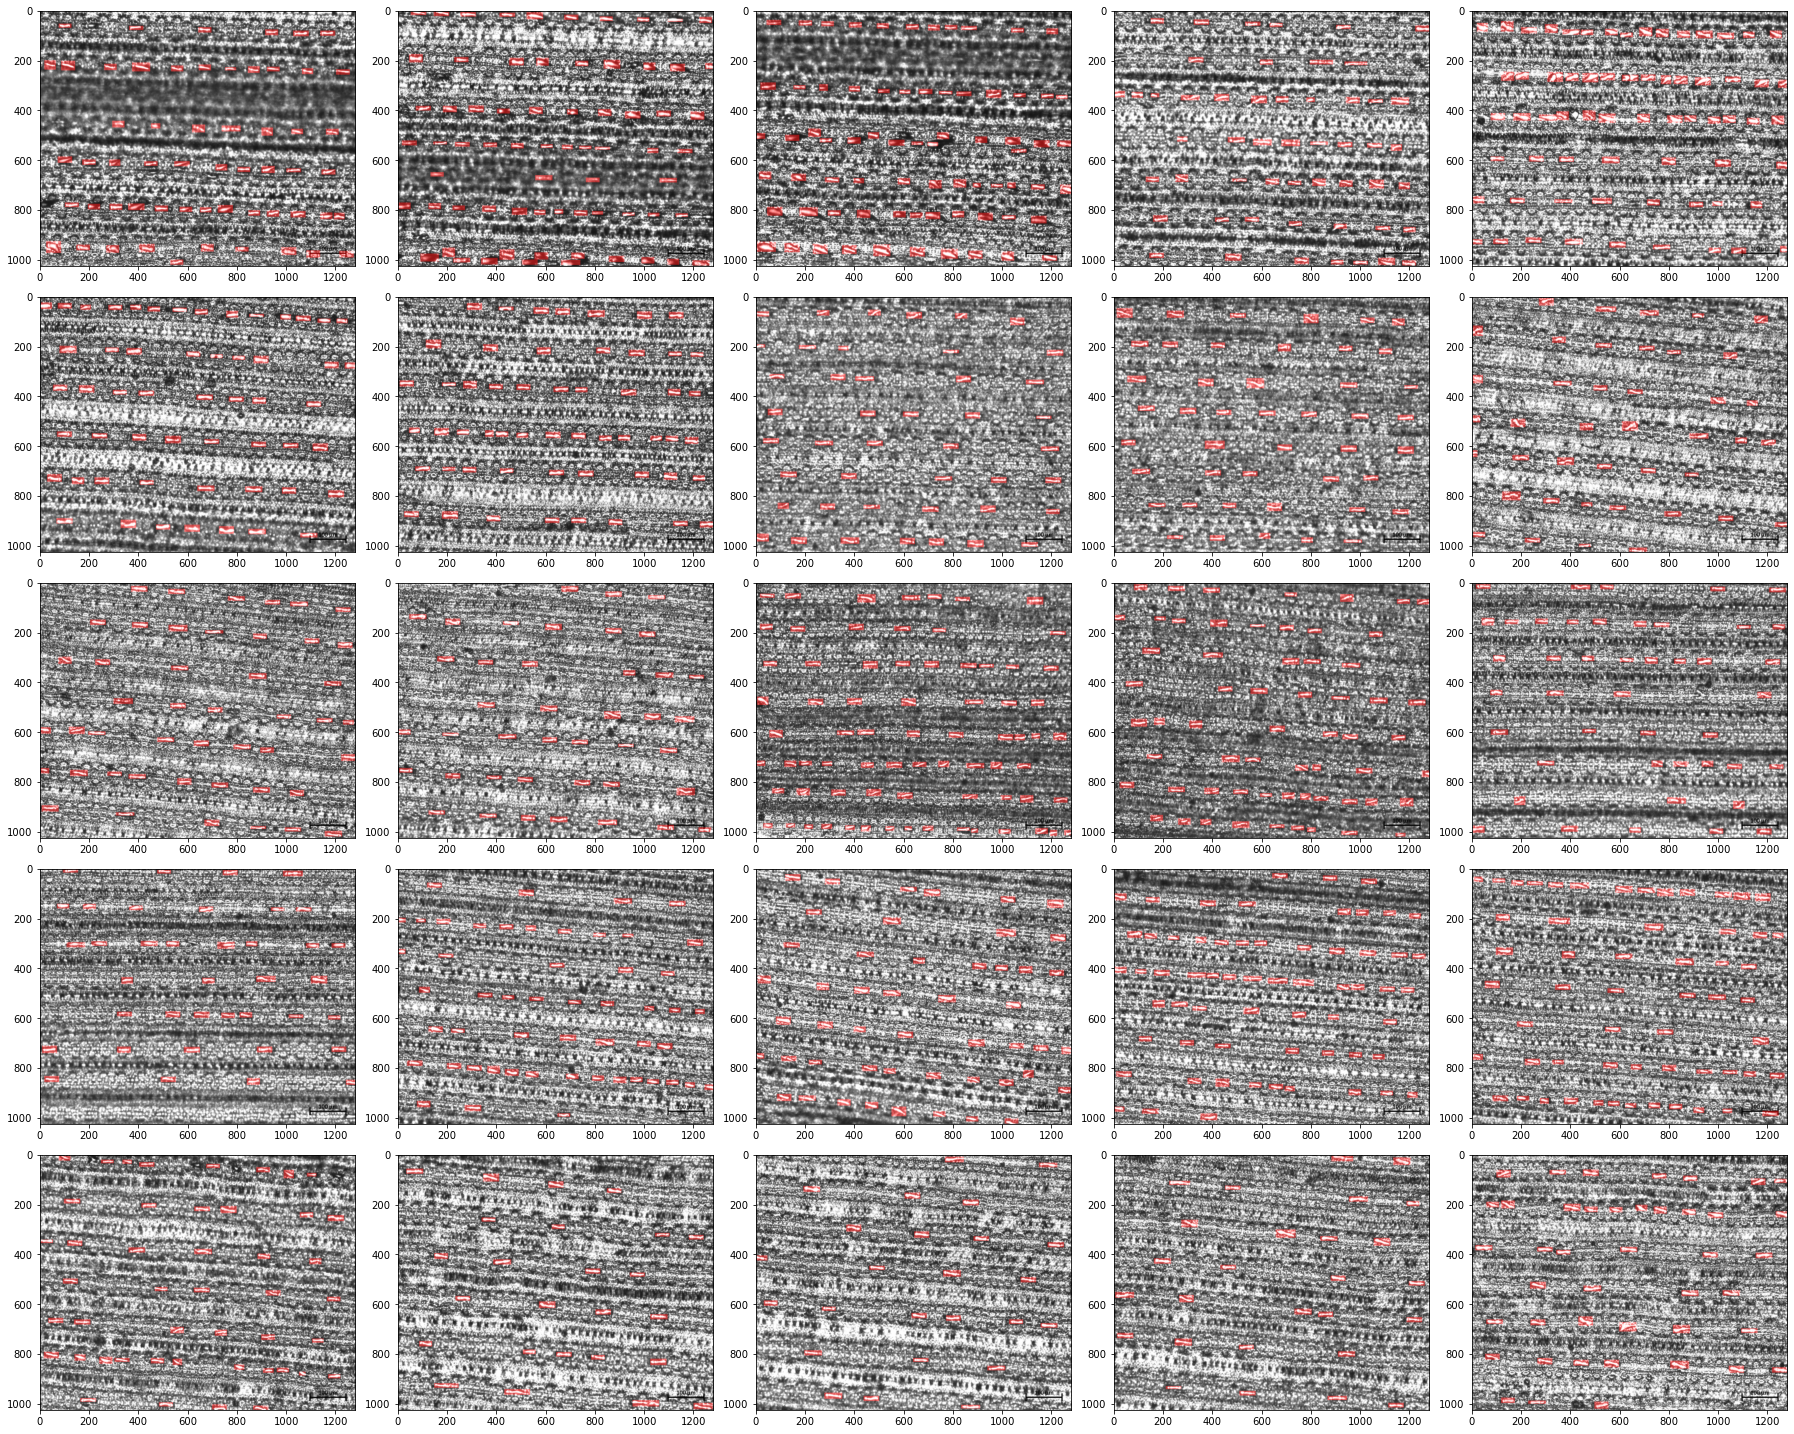

In [3]:
#
# load images and bounding boxes
#

# options
meta_path = '/mnt/DGX01/Personal/lagergrenj/Codebase/Data/Phenotype/UGA/salt_glands/meta/'
meta_names = ['Charlotte_annotations.json', 'Shreena_annotations.json']
image_path = '/mnt/DGX01/Personal/lagergrenj/Codebase/Data/Phenotype/UGA/salt_glands/images/'
shape = [1024, 1280] # reshaped to multiples of 256
verbose = True
plot = True
imsize = 4

# initialize loader
GL = GlandLoader(
    meta_path=meta_path,
    meta_names=meta_names,
    image_path=image_path,
    shape=shape,
    verbose=verbose)

# load data
images, masks = GL.load_data()

# plot
if plot:
    if verbose:
        print('Plotting examples...')
    size = [images[0].shape[0], images[0].shape[1]]
    fig = plt.figure(figsize=(5*size[1]/size[0]*imsize, 5*imsize))
    for i in range(25):
        image, mask = images[i].copy(), masks[i].copy()
        image = np.concatenate([image, image, image], axis=-1)
        image[:, :, 0] += mask/2
        image = image.clip(0, 1)
        ax = fig.add_subplot(5, 5, i+1)
        plt.imshow(image, aspect='auto', cmap='gray')
        # for b in bbox:
        #     x, y, w, h = b
        #     plt.plot([x, x+w, x+w, x, x], [y, y, y+h, y+h, y], 'r-')
        #     plt.plot(x, y, 'bx')
        plt.xlim([0, image.shape[1]])
        plt.ylim([image.shape[0], 0])
    plt.tight_layout(pad=1)
    plt.show()

# Make data loader

In [4]:
import numpy as np
import torch, pdb
import h5py
import torchvision
import random

from torch.utils.data import Dataset
from skimage.segmentation import find_boundaries

class GlandDataset(Dataset):
    
    '''
    Args:
        images     (list): list of images with shape [H, W, C]
        masks      (list): list of masks with shape [H, W, C]
        window_size (int): input tile size
        n_cells     (int): number of cells in YOLO output
        n_tiles     (int): number of tiles to sample from each image
        augment    (bool): whether to apply image augmentation
    '''
    
    def __init__(
        self, 
        images,
        masks,
        window_size=128,
        n_cells=8,
        n_tiles=1,
        augment=False):
        
        # initialize
        super().__init__()
        self.images = images
        self.masks = masks
        self.window_size = window_size
        self.n_cells = n_cells
        self.n_tiles = n_tiles
        self.augment = augment
        
        # build array of image indices and shuffle
        self.indices = np.repeat(np.arange(len(images)), n_tiles)
        permutation = np.random.permutation(len(self.indices))
        self.indices = self.indices[permutation]
        
        # define row/col locations for sampling rotated tiles
        w = int(self.window_size/2)
        X, Y = np.meshgrid(np.arange(-w, w), np.arange(-w, w), indexing='ij')
        self.image_slice = np.concatenate([X.reshape(-1, 1), Y.reshape(-1, 1)], axis=1)
        
    def __len__(self):
        return len(self.indices)
    
    # swap image axes [H, W, C] -> [C, H, W]
    def channels_first(self, image):
        return np.swapaxes(np.swapaxes(image, 0, 2), 1, 2)
    
    # swap image axes [C, H, W] -> [H, W, C]
    def channels_last(self, image):
        return np.swapaxes(np.swapaxes(image, 0, 2), 0, 1)
    
    # convert numpy image to torch tensor [C, H, W]
    def image2torch(self, image):
        image = torch.tensor(self.channels_first(image), dtype=torch.float32)
        return image
    
    # convert torch tensor to numpy image [H, W, C]
    def image2numpy(self, image):
        image = self.channels_last(image.detach().cpu().numpy())
        return image
    
    # convert numpy mask to torch tensor
    def mask2torch(self, mask):
        mask = torch.tensor(mask, dtype=torch.float32) # [H, W]
        return mask
    
    # convert torch tensor to numpy mask
    def mask2numpy(self, mask):
        mask = mask.detach().cpu().numpy() # [H, W]
        return mask
    
    # build rotation matrix based on angle (in radians)
    def build_rotation_matrix(self, theta):
        return np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    
    # build YOLO-type output from mask 
    def mask2yolo(self, mask):
            
        # initialize book keeping
        n_pixels = self.window_size
        n_pixels_per_cell = n_pixels / self.n_cells
        target = torch.zeros([5, self.n_cells, self.n_cells], dtype=torch.float)

        # loop over each object in mask
        mask, _ = ndimage.label(mask)
        for label in np.sort(np.unique(mask))[1:]:
            
            # get object attributes in pixel coordinates
            args = np.argwhere(mask == label)
            top, bot = args[:,0].min(), args[:,0].max()
            left, right = args[:,1].min(), args[:,1].max()
            height = (bot - top)/2
            width = (right - left)/2
            row_center, col_center = top + height, left + width
            
            # avoid objects near boundary
            if row_center < 10 or row_center > mask.shape[0]-10:
                continue
            if col_center < 10 or col_center > mask.shape[1]-10:
                continue
            
            # find which cell object belongs to
            cell_row = int(row_center/n_pixels*self.n_cells)
            cell_col = int(col_center/n_pixels*self.n_cells)
            
            # convert pixel coordinates to cell coordinates
            r = (row_center - (cell_row*n_pixels_per_cell)) / n_pixels_per_cell
            c = (col_center - (cell_col*n_pixels_per_cell)) / n_pixels_per_cell
            h = height / n_pixels_per_cell
            w = width / n_pixels_per_cell
            
            # fill target information
            t = torch.tensor([1.0, r, c, h, w], dtype=torch.float)
            target[:, cell_row, cell_col] = t
        
        return target
    
    # convert YOLO-type target to segmentation mask
    def yolo2bbox(self, target, threshold=0.5):
        bboxes = []
        n_pixels_per_cell = self.window_size / self.n_cells
        locs = np.argwhere(target[0] > threshold)
        for loc in locs:
            cell_row, cell_col = loc[0], loc[1]
            r, c = target[1, cell_row, cell_col], target[2, cell_row, cell_col]
            h, w = target[3, cell_row, cell_col], target[4, cell_row, cell_col]
            row_center = cell_row*n_pixels_per_cell + r*n_pixels_per_cell
            col_center = cell_col*n_pixels_per_cell + c*n_pixels_per_cell
            height = h * n_pixels_per_cell
            width = w * n_pixels_per_cell
            top, bot = int(row_center - height), int(row_center + height)
            left, right = int(col_center - width), int(col_center + width)
            bboxes.append([left, top, 2*width, 2*height])
        return bboxes

    def __getitem__(self, idx):

        # get image attributes
        w = self.window_size
        image_idx = self.indices[idx]
        H, W, C = self.images[image_idx].shape
        
        # optionally apply rotation and scaling
        e = int((w**2 + w**2)**0.5 + 1)
        row = np.random.choice(H - 2*e) + e
        col = np.random.choice(W - 2*e) + e
        theta = np.random.choice(np.linspace(-np.pi/12, np.pi/12, 360)) if self.augment else 0
        rotation = self.build_rotation_matrix(theta)
        locs = np.dot(rotation, self.image_slice.T).T
        scale = np.random.choice(np.linspace(0.8, 1.2, 101)) if self.augment else 1
        locs = np.round(np.array([[row, col]]) + scale*locs).astype(int)
        
        # extract tiles by (augmented) pixel locations, convert to torch
        tile = self.images[image_idx][locs[:, 0], locs[:, 1]].reshape(w, w, 1)
        mask = self.masks[image_idx][locs[:, 0], locs[:, 1]].reshape(w, w)
        
        tile = self.image2torch(tile.astype(np.float32))
        mask = self.mask2torch(np.round(mask.astype(np.float32)))

        # optionally apply random augmentations
        if self.augment:
        
             # random flips
            if random.random() > 0.5:
                tile = torchvision.transforms.functional.hflip(tile)
                mask = torchvision.transforms.functional.hflip(mask)
            if random.random() > 0.5:
                tile = torchvision.transforms.functional.vflip(tile)
                mask = torchvision.transforms.functional.vflip(mask)
            
            # random brightness
            tile = tile * (0.25*np.random.randn() + 1)
            
            # random noise
            tile = tile + 0.1*torch.randn_like(tile)
            
            # random blur
            kernel = np.random.choice([2*i+1 for i in range(10)])
            tile = torchvision.transforms.GaussianBlur(
                kernel_size=kernel, sigma=(0.1, 10))(tile)
            
            # clamp
            tile = tile.clamp(0, 1)
            mask = torch.round(mask)
            
        # convert segmentation mask to yolo output
        target = self.mask2yolo(self.mask2numpy(mask))
        
        return tile, target

Plotting examples...


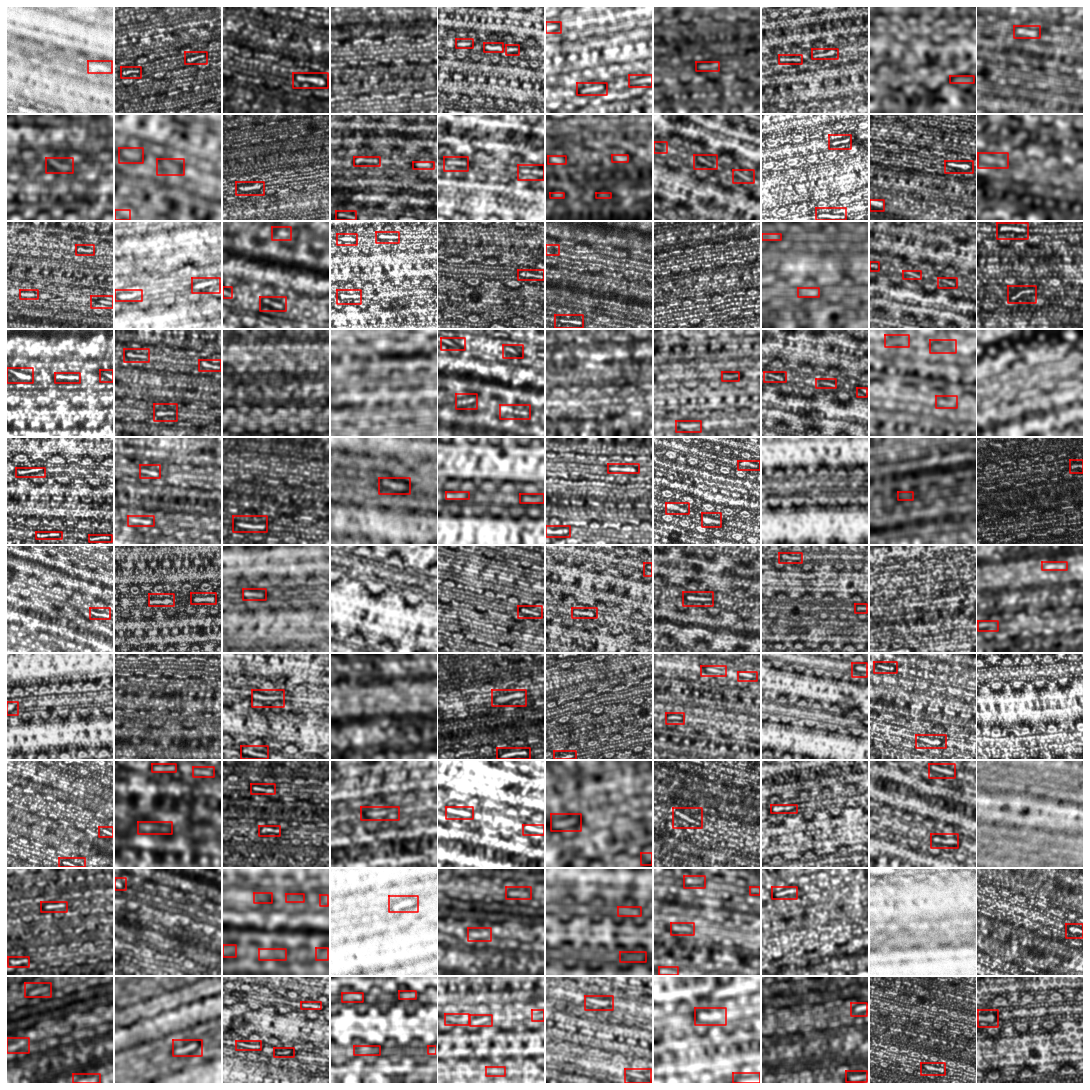

In [5]:
# options
window_size = 256
n_cells = 16
n_tiles = 1000
p = np.random.permutation(len(images))
train_img_idx = p[:int(0.8*len(p))]
val_img_idx = p[int(0.8*len(p)):]
plot = True

# instantiate data loaders
train_dataset = GlandDataset(
    images=[images[i] for i in train_img_idx], 
    masks=[masks[i] for i in train_img_idx], 
    window_size=window_size,
    n_cells=n_cells,
    n_tiles=n_tiles, 
    augment=True)
val_dataset = GlandDataset(
    images=[images[i] for i in val_img_idx], 
    masks=[masks[i] for i in val_img_idx], 
    window_size=window_size,
    n_cells=n_cells,
    n_tiles=n_tiles, 
    augment=False)

# plot example input/output tiles
if plot:
    print('Plotting examples...')
    N = len(train_dataset)
    fig = plt.figure(figsize=(15,15))
    for i in range(100):
        rand_idx = np.random.choice(N)
        tile, target = train_dataset[rand_idx]
        tile, target = tile.detach().cpu().numpy(), target.detach().cpu().numpy()
        bbox = train_dataset.yolo2bbox(target)
        ax = fig.add_subplot(10, 10, i+1)
        plt.imshow(tile[0], aspect='auto', cmap='gray')#, vmin=0, vmax=1)
        for b in bbox:
            x, y, w, h = b
            plt.plot([x, x+w, x+w, x, x], [y, y, y+h, y+h, y], 'r-')
        plt.axis('off')
    plt.tight_layout(pad=0.2)
    plt.show()

# Train GlandDetector

In [6]:
class CNN(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.cnn = BuildCNN.BuildCNN(
            input_channels=1,
            layers=[32, 32, 32, 64, 128],
            activation=torch.nn.LeakyReLU(),
            pool='conv',
            num_convs=3,
            use_batchnorm=True,
            dropout_rate=0.1)
        self.conv = torch.nn.Conv2d(
            in_channels=self.cnn.layers[-1],
            out_channels=5,
            kernel_size=3,
            stride=1,
            padding=1)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        x = self.cnn(x) # [B, 1, W, W] -> [B, C, 16, 16]
        x = self.conv(x) # [B, C, 16, 16] -> [B, 5, 16, 16]
        x = torch.cat([self.sigmoid(x[:,0:1]), x[:,1:]], dim=1)
        return x
    
# initialize model
cnn = CNN().to(device)
opt = torch.optim.Adam(cnn.parameters(), lr=1e-3)

# define loss function
def YOLOLoss(pred, true):
    mask = true[:,0] > 0.5
    obj = ((pred[:,0][mask]-true[:,0][mask])**2).mean()
    noobj = ((pred[:,0][~mask]-true[:,0][~mask])**2).mean()
    r = ((pred[:,1][mask]-true[:,1][mask])**2).mean()
    c = ((pred[:,2][mask]-true[:,2][mask])**2).mean()
    h = ((pred[:,3][mask]-true[:,3][mask])**2).mean()
    w = ((pred[:,4][mask]-true[:,4][mask])**2).mean()
    return obj + 4*noobj + r + c + h + w

def ObjLoss(pred, true):
    mask = true[:,0] > 0.5
    obj = ((pred[:,0][mask]-true[:,0][mask])**2).mean()
    noobj = ((pred[:,0][~mask]-true[:,0][~mask])**2).mean()
    return obj + noobj

def BndryLoss(pred, true):
    mask = true[:,0] > 0.5
    r = ((pred[:,1][mask]-true[:,1][mask])**2).mean()
    c = ((pred[:,2][mask]-true[:,2][mask])**2).mean()
    h = ((pred[:,3][mask]-true[:,3][mask])**2).mean()
    w = ((pred[:,4][mask]-true[:,4][mask])**2).mean()
    return r + c + h + w

# wrap
name = 'saltgland_detector{0}'.format(window_size)
model = MW.ModelWrapper(
    model=cnn,
    optimizer=opt,
    loss=[ObjLoss, BndryLoss],
    save_name='../Weights/'+name,
    device=device)

In [7]:
epochs = 1000
batch_size = 128
workers = 64
early_stopping = 10

# train one epoch
model.fit(
    train_dataset=train_dataset,
    validation_dataset=val_dataset,
    batch_size=batch_size,
    epochs=epochs,
    early_stopping=early_stopping,
    verbose=2,
    workers=workers)

Using PCGrad for optimization.
Epoch    1 562/562 | Train loss = 6.5674e-01 | Val loss = 1.9392e-01 *                 
Epoch    2 562/562 | Train loss = 3.1769e-01 | Val loss = 1.5791e-01 *                 
Epoch    3 562/562 | Train loss = 2.0872e-01 | Val loss = 1.4450e-01 *                 
Epoch    4 562/562 | Train loss = 1.7457e-01 | Val loss = 1.3680e-01 *                 
Epoch    5 562/562 | Train loss = 1.5391e-01 | Val loss = 1.2273e-01 *                 
Epoch    6 562/562 | Train loss = 1.3707e-01 | Val loss = 1.2220e-01 *                 
Epoch    7 562/562 | Train loss = 1.3503e-01 | Val loss = 1.2445e-01                 
Epoch    8 562/562 | Train loss = 1.2472e-01 | Val loss = 1.1183e-01 *                 
Epoch    9 562/562 | Train loss = 1.1795e-01 | Val loss = 1.1134e-01 *                 
Epoch   10 562/562 | Train loss = 1.1922e-01 | Val loss = 1.1050e-01 *                 
Epoch   11 562/562 | Train loss = 1.1114e-01 | Val loss = 1.3182e-01                 
Epoch

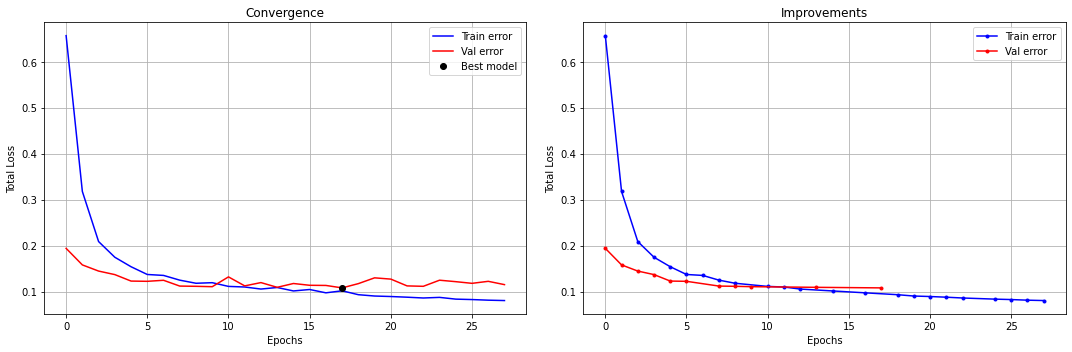

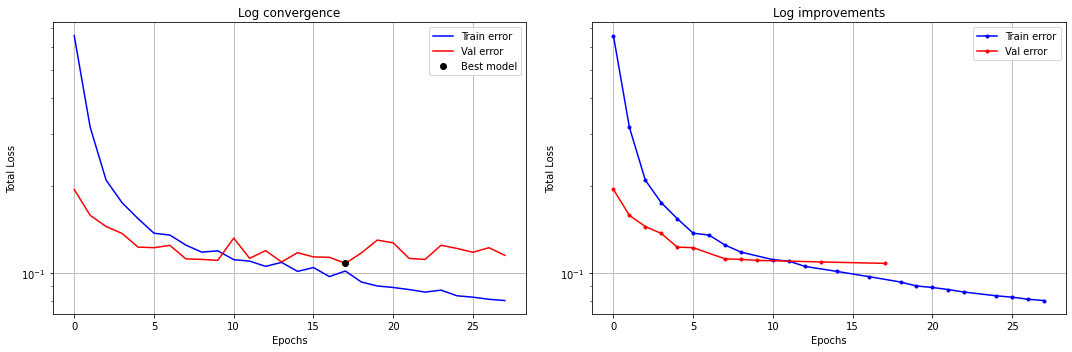

In [8]:
rel_save_thresh = 0.0

# load training errors
total_train_losses = model.train_loss_list
total_val_losses = model.val_loss_list

# find where errors decreased
train_idx, train_loss, val_idx, val_loss = [], [], [], []
best_train, best_val = 1e12, 1e12
for i in range(len(total_train_losses)):
    rel_diff = (best_train - total_train_losses[i])
    rel_diff /= best_train
    if rel_diff > rel_save_thresh:
        best_train = total_train_losses[i]
        train_idx.append(i)
        train_loss.append(best_train)
    rel_diff = (best_val - total_val_losses[i])
    rel_diff /= best_val
    if rel_diff > rel_save_thresh:
        best_val = total_val_losses[i]
        val_idx.append(i)
        val_loss.append(best_val)
idx = np.argmin(val_loss)

# plot
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(total_train_losses, 'b')
plt.plot(total_val_losses, 'r')
plt.plot(val_idx[idx], val_loss[idx], 'ko')
plt.legend([r'Train error', r'Val error', 'Best model'])
plt.xlabel(r'Epochs')
plt.ylabel(r'Total Loss')
plt.title(r'Convergence')
plt.grid()
ax = fig.add_subplot(1, 2, 2)
plt.plot(train_idx, train_loss, 'b.-')
plt.plot(val_idx, val_loss, 'r.-')
plt.legend([r'Train error', r'Val error'])
plt.xlabel('Epochs')
plt.ylabel(r'Total Loss')
plt.title(r'Improvements')
plt.grid()
plt.tight_layout(h_pad=2, w_pad=2)
plt.show()

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1, 2, 1)
plt.semilogy(total_train_losses, 'b')
plt.semilogy(total_val_losses, 'r')
plt.semilogy(val_idx[idx], val_loss[idx], 'ko')
plt.legend([r'Train error', r'Val error', 'Best model'])
plt.xlabel(r'Epochs')
plt.ylabel(r'Total Loss')
plt.title(r'Log convergence')
plt.grid()
ax = fig.add_subplot(1, 2, 2)
plt.semilogy(train_idx, train_loss, 'b.-')
plt.semilogy(val_idx, val_loss, 'r.-')
plt.legend([r'Train error', r'Val error'])
plt.xlabel('Epochs')
plt.ylabel(r'Total Loss')
plt.title(r'Log improvements')
plt.grid()
plt.tight_layout(h_pad=2, w_pad=2)
plt.show()

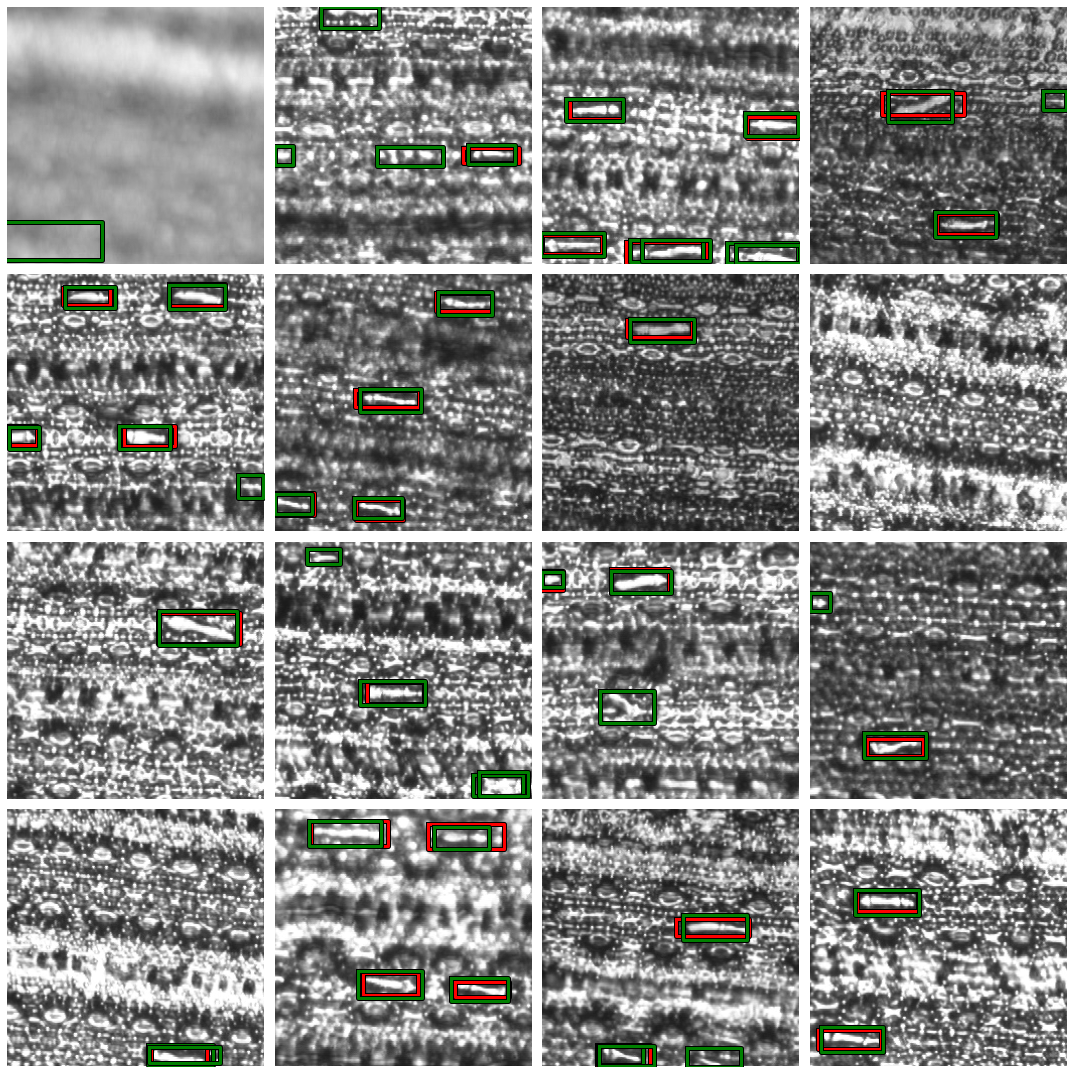

In [9]:
#
# evaluate on random validation tiles
#

# options
threshold = 0.5

model.load_best_val()

def prune_pred_mask(mask, threshold=0.5):
    for i in range(mask.shape[0]-1):
        for j in range(mask.shape[1]-1):
            if mask[i,j] > threshold:
                mask[i,j] = 0 if mask[i+1,j] > mask[i,j] else mask[i,j]
                mask[i+1,j] = 0 if mask[i,j] > mask[i+1,j] else mask[i+1,j]
                mask[i,j] = 0 if mask[i,j+1] > mask[i,j] else mask[i,j]
                mask[i,j+1] = 0 if mask[i,j] > mask[i,j+1] else mask[i,j+1]
                mask[i,j] = 0 if mask[i+1,j+1] > mask[i,j] else mask[i,j]
                mask[i+1,j+1] = 0 if mask[i,j] > mask[i+1,j+1] else mask[i+1,j+1]
    return mask

# plot example input/output tiles
fig = plt.figure(figsize=(15,15))
N = len(val_dataset)
for i in range(16):
    rand_idx = np.random.choice(N)
    tile, true = val_dataset[rand_idx]
    pred = cnn(tile[None].to(device))[0]
    tile = tile.detach().cpu().numpy()
    true = true.detach().cpu().numpy()
    pred = pred.detach().cpu().numpy()
    pred[0] = prune_pred_mask(pred[0], threshold)
    ax = fig.add_subplot(4, 4, i+1)
    plt.imshow(tile[0], aspect='auto', cmap='gray', vmin=0, vmax=1)
    for b in val_dataset.yolo2bbox(true, threshold=threshold):
        x, y, w, h = b
        plt.plot([x, x+w, x+w, x, x], [y, y, y+h, y+h, y], 'k-', linewidth=5)
        plt.plot([x, x+w, x+w, x, x], [y, y, y+h, y+h, y], 'r-', linewidth=3)
    for b in val_dataset.yolo2bbox(pred, threshold=threshold):
        x, y, w, h = b
        plt.plot([x, x+w, x+w, x, x], [y, y, y+h, y+h, y], 'k-', linewidth=5)
        plt.plot([x, x+w, x+w, x, x], [y, y, y+h, y+h, y], 'g-', linewidth=3)
    plt.xlim([0, window_size])
    plt.ylim([window_size, 0])
    plt.axis('off')
plt.tight_layout(pad=1)
plt.show()

# Inference on test data

In [51]:
from PIL import Image, ImageOps
from scipy import ndimage
from tqdm.notebook import tqdm

# image options
date = '220728' # 220125 220728
test_path = base_path + 'Data/Phenotype/UGA/salt_glands/test_{0}/images/'.format(date)
test_names = glob.glob(test_path+'*.jpeg') + glob.glob(test_path+'*.jpg')
test_names = [os.path.basename(t) for t in test_names]
test_names.sort()
test_shape = [1024, 1280]

# inference options
step_size = 128
threshold = 0.9
iou_threshold = 0.1
verbose = False
show = False # show plots in jupyter notebook
save = True # save plots to png
write = True # write bbox coordinates in csv
plot_path = base_path + 'Data/Phenotype/UGA/salt_glands/test_{0}/preds/'.format(date)
write_path = base_path + 'Data/Phenotype/UGA/salt_glands/test_{0}/'.format(date)
model.load_best_val()

# initialize CSV file
if write:
    with open(write_path + 'bbox_predictions_{0}.csv'.format(date), 'w') as f:
        f.writelines('id,x,y,h,w\n')
        
# loop over test images
for name in tqdm(test_names):
    
    #
    # load image
    #

    # load image
    image = ImageOps.grayscale(Image.open(test_path + name)) 
    old_shape = image.size[::-1]
    old_image = np.array(image, dtype=float)/255
    
    # reshape and convert to numpy
    image = image.resize(test_shape[::-1]) # reshape to [N*256, M*256]
    image = np.array(image, dtype=float)/255

    #
    # run model
    #
    
    # book keeping
    n_row_steps = int((image.shape[0])/step_size)
    n_col_steps = int((image.shape[1])/step_size)
    n_pixels_per_cell = int(window_size/n_cells)
    
    # convolve model over image patches
    scores, bboxes = [], []
    for r_idx in range(n_row_steps):
        for c_idx in range(n_col_steps):

            # cnn prediction
            r_min, r_max = r_idx*step_size, r_idx*step_size + window_size
            c_min, c_max = c_idx*step_size, c_idx*step_size + window_size
            tile = image[r_min:r_max, c_min:c_max, None]
            pred = cnn(val_dataset.image2torch(tile).to(device)[None])[0]
            pred = pred.detach().cpu().numpy()
            if r_idx > 0: pred[0,:2,:] = 0
            if r_idx < n_row_steps-1: pred[0,-2:,:] = 0
            if c_idx > 0: pred[0,:,:2] = 0
            if c_idx < n_col_steps-1: pred[0,:,-2:] = 0

            # apply threshold
            locs = np.argwhere(pred[0] > threshold)
            score = pred[0][locs[:, 0], locs[:, 1]]
            bbox = [pred[i+1][locs[:, 0], locs[:, 1]][:,None] for i in range(4)]
            bbox = np.concatenate(bbox, axis=1)

            # convert bbox coords to global coords
            r, c, h, w = bbox.T
            row = locs[:,0]*n_pixels_per_cell + r*n_pixels_per_cell + r_idx*step_size
            col = locs[:,1]*n_pixels_per_cell + c*n_pixels_per_cell + c_idx*step_size
            height = h * n_pixels_per_cell
            width = w * n_pixels_per_cell
            top, bot = (row - height).clip(0, image.shape[0]-1), (row + height).clip(0, image.shape[0]-1)
            left, right = (col - width).clip(0, image.shape[1]-1), (col + width).clip(0, image.shape[1]-1)
            bbox = np.concatenate([top[:,None], left[:,None], bot[:,None], right[:,None]], axis=1)

            # store results
            scores.append(score)
            bboxes.append(bbox)

    # combine results and sort
    scores = np.concatenate(scores, axis=0) # [N]
    bboxes = np.concatenate(bboxes, axis=0) # [N, 4]
    
    #
    # post-processing
    #
    
    # initialize plot
    if show:
        fig = plt.figure(figsize=(image.shape[1]/image.shape[0]*15,15))
        plt.imshow(image, aspect='auto', cmap='gray', vmin=0, vmax=1)
        for bbox in bboxes:
            top, left, bot, right = bbox
            plt.plot([left, left, right, right, left], [bot, top, top, bot, bot], 'g-')
            
    # prune by boosted non-max suppression
    if verbose:
        print('Applying NMS...')
    heights, widths = bboxes[:,2] - bboxes[:,0], bboxes[:,3] - bboxes[:,1]
    dh, dw = np.abs(heights - np.median(heights)), np.abs(widths - np.median(widths))
    dists = dh + dw
    boost = 1 - dists/dists.max()
    idx = torchvision.ops.nms(
        boxes=torch.tensor(bboxes, dtype=torch.float32),
        scores=torch.tensor(scores*boost, dtype=torch.float32),
        iou_threshold=iou_threshold).detach().cpu().numpy()
    scores, bboxes = scores[idx], bboxes[idx]
    
    # finalize plot
    if show:
        for bbox in bboxes:
            top, left, bot, right = bbox
            plt.plot([left, left, right, right, left], [bot, top, top, bot, bot], 'r-')
        plt.xlim([0, image.shape[1]-1])
        plt.ylim([image.shape[0]-1, 0])
        plt.axis('off')
        plt.title(os.path.basename(name))
        plt.show()
        
    # if saving to png or csv
    if save or write:
        
        # compute quantities for rescaling back to original image
        x_scale = old_shape[1]/test_shape[1]
        y_scale = old_shape[0]/test_shape[0]
        
        mask = np.zeros_like(old_image).astype(bool)
        for bbox in bboxes:
            
            # scale bbox coordinates
            top, left, bot, right = bbox
            x, y, h, w = left, top, bot-top, right-left
            x, y = round(x_scale*x), round(y_scale*y)
            h, w = round(y_scale*h), round(x_scale*w)
            
            # add bbox to mask
            mask[y:y+h, x], mask[y:y+h, x+w] = True, True
            mask[y, x:x+w], mask[y+h, x:x+w] = True, True
            
            if write:
                with open(write_path + 'bbox_predictions_{0}.csv'.format(date), 'a') as f:
                    f.writelines('{0},{1},{2},{3},{4}\n'.format(name, x, y, h, w))
                        
        # draw bounding boxes on original image and save
        if save:
            mask = ndimage.binary_dilation(mask, iterations=2)
            save_image = np.concatenate([
                old_image[:,:,None], old_image[:,:,None], old_image[:,:,None]], axis=-1)
            save_image[mask] = (1, 0, 0)
            save_image = Image.fromarray(np.uint8(255*save_image).clip(0, 255))
            save_image.save(plot_path + name.replace('.jpg', '.png'))

  0%|          | 0/113 [00:00<?, ?it/s]

Idea: hyperparameter validation using IoU over validation set

In [ ]:
#def prune_outliers(x, m=3):
#    dists = np.abs(x - np.median(x))
#    sigma = np.std(dists)
#    idx = np.argwhere(dists < m*sigma)[:, 0]
#    return idx

## prune by area
#areas = (bboxes[:,2] - bboxes[:,0]) * (bboxes[:,3] - bboxes[:,1])
#idx = prune_outliers(areas, m=4)
#scores, bboxes = scores[idx], bboxes[idx]

## prune by brightness
#brightness = np.array([image[b[0]:b[2], b[1]:b[3]].mean() for b in bboxes.astype(int)])
#idx = prune_outliers(brightness, m=4)
#scores, bboxes = scores[idx], bboxes[idx]

## prune by object characteristics
#x1, y1, x2, y2 = bboxes.astype(int).T
#height, width = int((x2 - x1).mean()), int((y2 - y1).mean())
#objects = [image[x1[i]:x2[i], y1[i]:y2[i]] for i in range(len(bboxes))]
#objects = [resize(o, [height, width]).reshape(-1)[None] for o in objects]
#objects = np.concatenate(objects, axis=0)
#dists = np.abs(objects - np.median(objects, axis=0, keepdims=True))
#sigma = np.std(dists, axis=0, keepdims=True)
#idx = np.argwhere((dists < 3*sigma).mean(-1) > 0.75)[:, 0]
#scores, bboxes = scores[idx], bboxes[idx]